<a href="https://colab.research.google.com/github/harmishpatel21/forecasting-crypto/blob/main/Data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [9]:
!pip install pandas_datareader

In [10]:
!pip install yfinance

In [11]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd

In [26]:
ticker = "ETH-USD"
startDate = "2010-01-01"
EndDate = "2021-04-01"
today = date.today()

In [27]:
files=[]
data = pdr.get_data_yahoo(ticker, start=startDate, end=today)
print(data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed
(2061, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329
2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188
2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170
2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283
2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100


In [28]:
data=data.reset_index()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100


In [29]:
print(max(data['Date']), min(data['Date']))

2021-04-01 00:00:00 2015-08-07 00:00:00


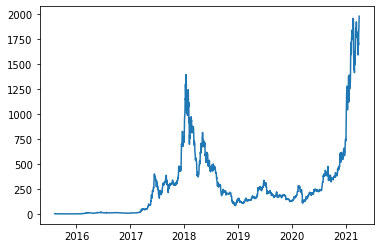

In [34]:
plt.plot(data['Date'],data['Close'])

In [35]:
df=data

In [36]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [39]:
for i in data.columns:
  print(type(data[i][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>


In [40]:
train_mean = train_df.mean()
print(type(train_mean))

<class 'pandas.core.series.Series'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [37]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


UFuncTypeError: ignored